<a href="https://colab.research.google.com/github/Melikakmm/GPR_fitting_interactive_potential/blob/main/fitpot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process regression for fitting interatomic potentials

## Workshop Aims
* Data representation using invariant descriptors
* Building covariance matrices for derived quantities - learning from total energy data
* Uncertainty analysis of predicted energy values
* Optimising hyperparameters
* Relaxing geometry using a machine learned potential



In [3]:
!alias gcc='gcc-11'
!alias cc='gcc-11'
!alias g++='g++-11'
!alias c++='c++-11'

In [1]:
pip install GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3211195 sha256=9be03910c3c8f7517a002bb00358f8382b663ef68888b3e397f1d1b331f468cf
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102544 sha256=b00737b1203427955fb4cfa95c3f2065a9514fc685369bcb1e84360a56e8a3fc
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built GPy paramz


In [2]:
pip install ase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.4 MB/s eta 0:00:00


In [3]:
pip install nglview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00
  Created wheel for nglview: filename=nglview-3.0.7-py3-none-any.whl size=10096145 sha256=320962c748fa5070b020c51023a89379733dc06d0f20212535f87018c60a3902
  Stored in directory: /root/.cache/pip/wheels/7a/09/68/d0d369f347c8fb4a8668b313744d9e83bb24d5c7060b962825
Successfully built nglview


In [21]:
import numpy as np
import pandas as pd
import GPy

from ase.io import read
import nglview

from IPython.display import display

%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [86]:
custom_style_gold = {
    'axes.labelcolor': 'blue',
    'axes.edgecolor': 'gray',
    'axes.facecolor': '#FFFFF0',
    'xtick.color': 'green',
    'ytick.color': 'red',
    'font.size': 15,
    'legend.fontsize': 12,
    'grid.color': '#E6DAA6',
}


In [89]:
plt.rcParams['figure.figsize'] = [25, 10]

## Part 1
### Learning the interaction energy of a single water molecule

The quantum mechanical energy of a water molecule - within the Born-Oppenheimer approximation - is a function of the geometry of the molecule, i.e. the Cartesian coordinates $\mathbf{r}_\rm{O}$, $\mathbf{r}_{\rm H_1}$ and  $\mathbf{r}_{\rm H_2}$. Of course, this energy does not depend on the orientation of the water molecule if there is no external field interacting with the molecule.

<img src="water.png">

We can rewrite the energy function as $E(\mathbf{r}_{\rm O},\mathbf{r}_{\rm H_1},\mathbf{r}_{\rm H_2}) \equiv E(r_{\rm OH_1},r_{\rm OH_2},\theta_{\rm HOH})$ where $r_{\rm OH}$ are the bond lengths and $\theta_{\rm HOH}$ the bond angle. This description is invariant to rotations and translations. We also know that the 'label' of the hydrogens is unimportant (i.e. swapping $\rm H_1$ and $\rm H_2$ does not change the energy), therefore it is useful to symmetrise the distances.

In this exercise, we will use the following data coordinates:
* $r_+ = r_{\rm OH_1} + r_{\rm OH_2}$
* $r_- = (r_{\rm OH_1} - r_{\rm OH_2})^2$
* $a = \mathbf{r}_{\rm OH_1} \cdot \mathbf{r}_{\rm OH_2}$

### Question 1

**Explain why the descriptor functions $r_+$, $r_-$ and $a$ are invariant to rigid rotations, translations of the molecule and permutations of the hydrogen indices.**

answer: due to the symmetry of the water molecule around the oxygen axis, $r_+$, and $r_-$ are both invariant against any translation and rotation. Moreover, because $\mathbf{r}_{\rm OH_1}$ and $\mathbf{r}_{\rm OH_2}$ vectors are relative positional vectors and are not coming from the origin of the coordinates, they are also invariant to rigid rotation and translation of the molecule.






In [6]:
# Read in water configurations
water_configs = read("water_configs.xyz", format="extxyz", index=":")
# There should be 2886 independent water molecules
print(len(water_configs))

2886


In [7]:
water_configs[0:10]

[Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator(...)),
 Atoms(symbols='OH2', pbc=True, cell=[30.0, 30.0, 30.0], map_shift=..., n_neighb=..., calculator=SinglePointCalculator

In [9]:
# optional - for visualisation
nglview.show_asetraj(water_configs)

NGLWidget(max_frame=2885)

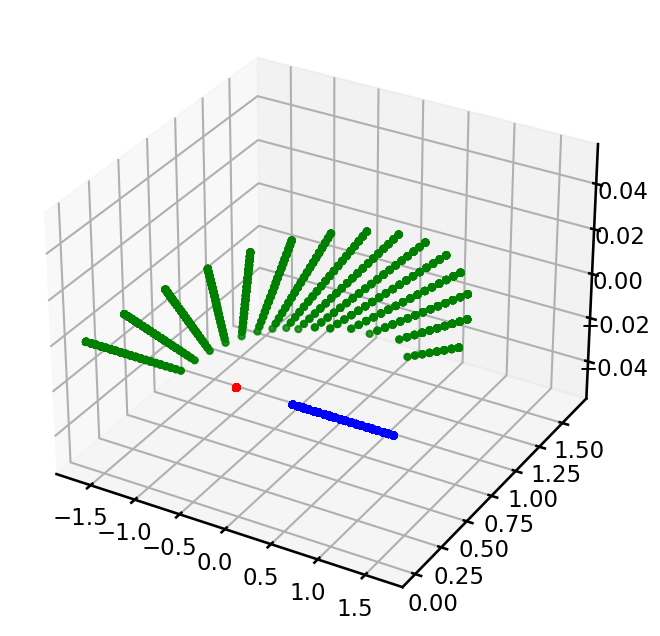

In [46]:
O = []

H1 = []

H2 = []


for a in water_configs:
    p = a.get_positions()
    O.append(p[0])
    H1.append(p[1])
    H2.append(p[2])

coordin = ['x', 'y', 'z']
atoms = ['O', 'H1', 'H2']

for a in atoms:
  exec(f"{a}_x = []")
  exec(f"{a}_y = []")
  exec(f"{a}_z = []")
  atom = globals()[f"{a}"]


  for array in atom:
    globals()[f"{a}_x"].append(array[0])
    globals()[f"{a}_y"].append(array[1])
    globals()[f"{a}_z"].append(array[2])





ax = plt.axes(projection = '3d')
ax.scatter(O_x, O_y, O_z, color = 'red')
ax.scatter(H1_x, H1_y, H1_z, color = 'blue')
ax.scatter(H2_x, H2_y, H2_z, color = 'green')




In [50]:
x = [] # input features
y = [] # target values

# Calculating descriptor vectors for each molecule and collect target energies
for a in water_configs:
    p = a.get_positions() # positions: O, H1, H2
    rOH1 = a.get_distance(0, 1)# calculating distance OH1
    rOH2 = a.get_distance(0, 2)# calculating distances OH2
    aHOH = np.dot(p[1]-p[0], p[2]-p[0])# dot product between the vectors OH1 and OH2
    # <Here rOH1 and rOH2 are only distances and aHOH is a dot product of two vectors.>
    x.append([(rOH1 + rOH2), (rOH1 - rOH2)**2, aHOH]) # collect descriptors, they are all scalars.

    y.append(a.get_potential_energy()) # QM energy of a water molecule

We randomly split the data to a train and test set and then use it to train a Gaussian process regression model using `GPy`.

In [51]:
from sklearn.model_selection import train_test_split

# test_size sets the fraction of the test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.9)

X_train = np.array(X_train) # a vector of the 3 descriptors.
y_train = np.array(y_train)[:, None] # GPy needs a 2D array, y_train is a (288, 1) dimensional array of (1,) dimensional arrays

y_train.shape

(288, 1)

The Radial Basis Function (RBF) kernel, also known as the Gaussian kernel, is a popular and widely used kernel function in machine learning and particularly in the context of kernel methods and Gaussian processes. It is used to measure the similarity or distance between data points in a high-dimensional space. The RBF kernel is defined as:

$$ K(x, x') = exp(- {\frac {||x -x'||}{2 {σ^2}}})$$

* $K(x, x')$ : This represents the similarity or kernel value between two data points
x and x'.

* $∣∣x−x'∣∣$  : These are vectors representing the data points in a high-dimensional feature space. The RBF kernel measures the similarity between these vectors.

* $σ^2$ : This is a hyperparameter called the `bandwidth` or `lengthscale` parameter. It controls the spread or width of the kernel function. A smaller $σ^2$ results in a narrow kernel with high similarity values for nearby data points, while a larger $σ^2$ results in a wider kernel with similarity values that decay more slowly with distance.

In [52]:
# input_dim: dimensionality of data points - our descriptor vectors have three elements
# variance: range (squared) of the function
print("Range of input data: {:.2f}".format(y_train.max()-y_train.min()))
# lengthscale: characteristic lengthscale - start with a default of 0.5
# ARD: automatic relevance determination - allows separate lengthscales for each three descriptor dimensions

kernel = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=10.,ARD=True) # ARD : seperate length scale for each input

# the values we chose for the hyperparameters are the initial values.
# they wil be updated during the the optimization.

Range of input data: 15.17


## What is ARD in the code above ?

Using "automatic relevance determination" (ARD) or separate length scales for each input dimension in Gaussian process regression can be useful in certain cases because it allows the model to capture different degrees of influence or importance of each input dimension on the output. This can lead to more `flexible` and `accurate` models in situations where the relationships between inputs and outputs are not isotropic (i.e., the influence of each dimension varies).





### Question 2.a

**Why is it useful to use 'automatic relevance determination' (separate lengthscales, rather than one for all three dimensions) in this situation?** we have chosen ARD to be True eventhough we have used the same length scale for all input dimensions. This is because we want the model to be flexible and understand that these three inputs might have different influeneces on the process.

In [53]:
# Generate a Gaussian Process model by adding training data. Start with a small noise parameter.
m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)

# the more we decrease the lengthscale, the more the model captures the details.
# it creates a sort of local sensitivity.

In [55]:
# Optimise the likelihood with respect of the hyperparameters of the model
m.optimize_restarts(num_restarts = 10);

 /usr/local/lib/python3.10/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -172.0300322908111
Optimization restart 2/10, f = -172.03003312244476
Optimization restart 3/10, f = -172.0300308023547
Optimization restart 4/10, f = -172.03002997564187
Optimization restart 5/10, f = -172.03003195600064
Optimization restart 6/10, f = -172.03002984038477
Optimization restart 7/10, f = -172.03003265718695
Optimization restart 8/10, f = -172.030029684265
Optimization restart 9/10, f = -172.03003066150274
Optimization restart 10/10, f = -172.03003166957336


### Question 2.b

**When optimising the hyperparameters, what do we mean by restarts and why is it useful to do more than one?**

a "restart" refers to the process of initializing the optimization algorithm multiple times from different initial points. Each of these initial points is randomly chosen or selected according to some predefined strategy.


The motivation behind using multiple restarts is to improve the chances of finding the global optimum or a better local optimum in non-convex optimization problems

In [16]:
# Print the result of the likelihood optimisation
display(m)
m.rbf.lengthscale

GP_regression.,value,constraints,priors
rbf.variance,70422.96475460209,+ve,
rbf.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,3.5781788304594034e-05,+ve,


index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.79614656,+ve,
[1],1.99505866,+ve,
[2],1.20146988,+ve,


`m` contains the trained model: a combination of the _prior_ (in the form of the kernel and its hyperparameters, as well as the noise model) and _data_ (in the form of geometrical descriptors and corresponding energy values).

### Question 2.c

**From the output of the previous cell, what is the noise variance of the optimal model? What does this tell us about the data?**

The noise variance reflects how well the Gaussian process model fits the training data. A lower noise variance indicates that the model fits the data closely, as it implies that the observed data points have less variability around the mean predicted by the GP model.
Conversely, a higher noise variance suggests that there is more variability or uncertainty in the observed data, and the model doesn't fit the data as closely.



In GPR, setting the noise variance too low can lead to overfitting. When the noise variance is underestimated, the model may fit not only the underlying patterns in the data but also the noise itself.
By optimizing the noise variance along with other hyperparameters, we can find a balance that prevents overfitting and provides a more accurate representation of the true underlying process.

In [57]:
# Use the model to predict the energy of water configurations.

y_train_predict, y_train_error = m.predict(np.array(X_train)) # predict energies of training configurations
y_test_predict, y_test_error = m.predict(np.array(X_test))  # predict energies of the test set configurations

# root-mean-square error (RMSE)
rmse = np.sqrt(np.mean((np.array(y_test)-y_test_predict[:,0])**2))
print("RMSE = {:.3f} eV".format(rmse))

RMSE = 0.057 eV


### Question 2.d

**Plot graphs to show the correlation of actual and predicted energies, and of the actual and predicted error**

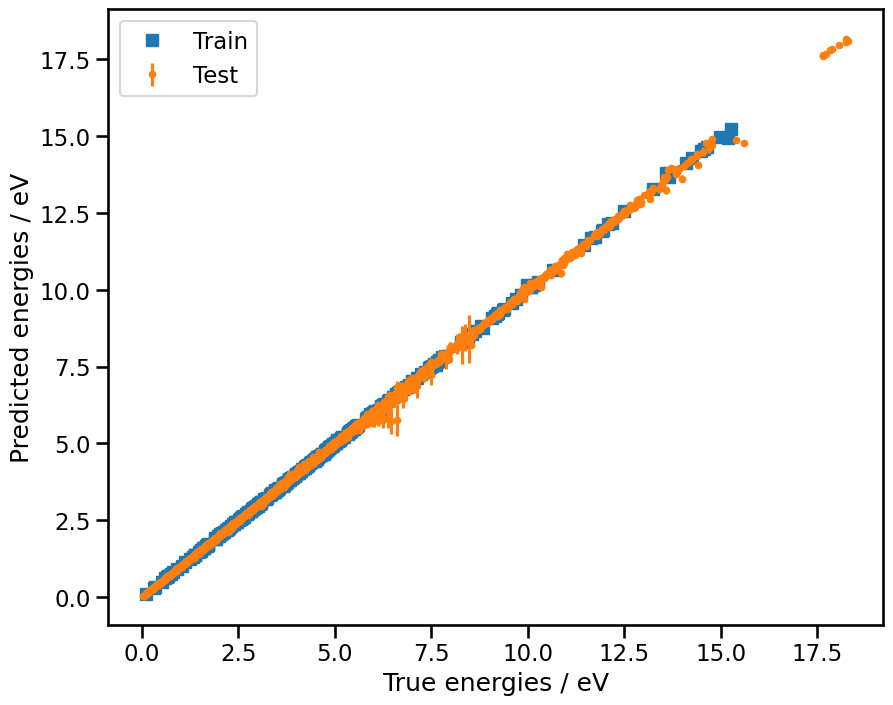

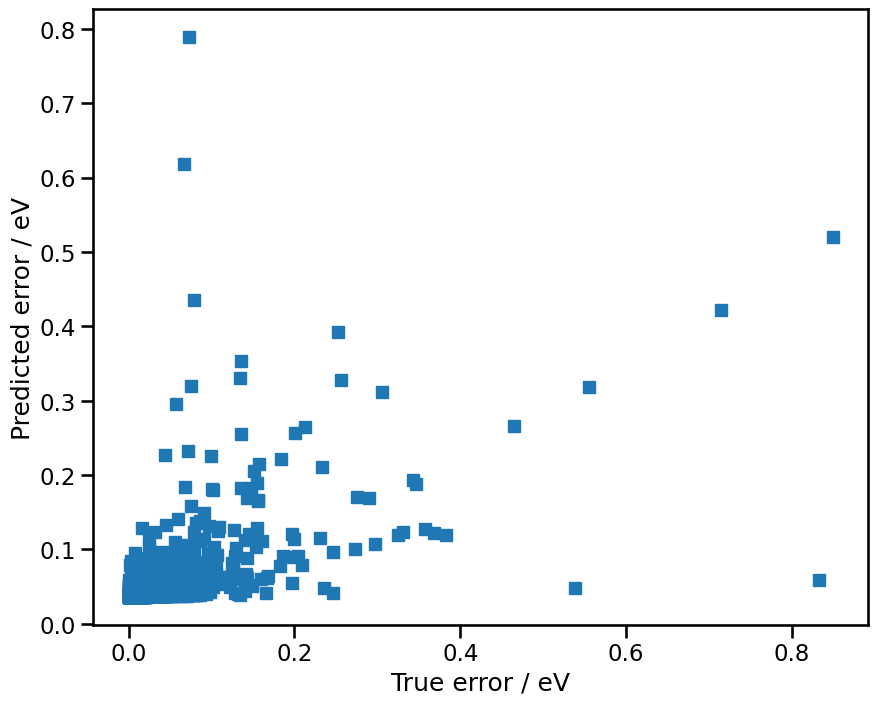

In [71]:
# Plot the correlation of actual and predicted data
plt.plot(y_train,y_train_predict,"s", label='Train')
plt.errorbar(y_test,y_test_predict[:,0],yerr=np.sqrt(y_test_error[:,0]),fmt=".", label='Test')
plt.xlabel('True energies / eV')
plt.ylabel('Predicted energies / eV')
plt.legend()
plt.show()

# Plot the correlation of actual and predicted error
plt.plot(np.abs(y_test-y_test_predict[:,0]), np.sqrt(y_test_error[:,0]),"s")
plt.xlabel('True error / eV')
plt.ylabel('Predicted error / eV')
plt.show()

TypeError: ignored

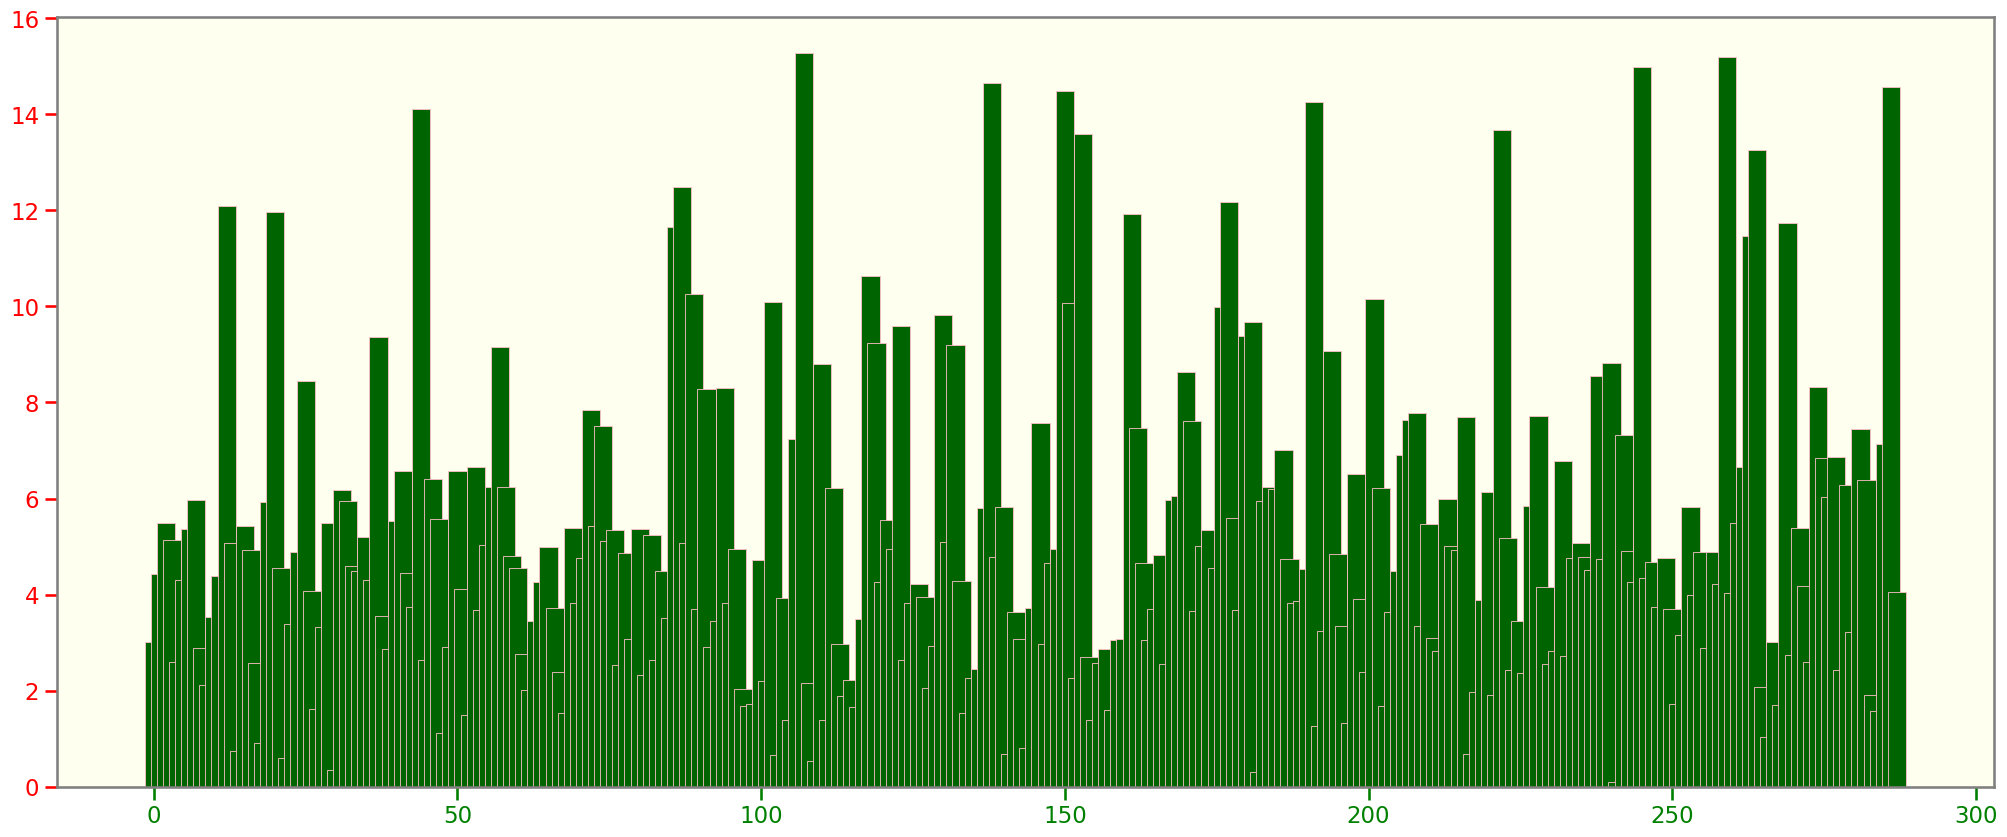

In [93]:
plt.style.use(custom_style_gold)

fig, ax = plt.subplots()
ax.bar(range(0, 288), y_train[:, 0], width = 3, color = 'darkgreen', edgecolor = 'pink', linewidth = 0.6)
ax.errorbar(range(288), y_train_predict, yerr = y_)

### Question 3.a

**Briefly disucss how accurate the Gaussian Process water model is. How accurate is the error prediction?** [5 marks]

YOUR ANSWER HERE

### Question 3.b

We only used 10% of the data for training. By adapting the code above, starting from where we split the data into test and train set, fit further GP models with different fractions (10%, 20%, 40%, 80%) of training data - don't forget to optimise the likelihood. Summarise in a table how the root mean squared error (RMSE) changes. Write a short paragraph about the advantages and disadvantages of using more training data. [5 marks code + 5 marks discussion]

In [52]:
import pandas as pd

df = pd.DataFrame(columns=['train_size', 'RMSE'])

df['train_size'] = [0.1, 0.2, 0.4, 0.8]

for i, train_size in enumerate(df.train_size):
    # split data
    X_train = np.array(X_train)
    y_train = np.array(y_train)[:, None]
    # create modeel
    # optimise
    # predict on test set y_test_predict, y_test_error =
    rmse =
    print(train_size, rmse)
    df.iloc[i, 1] = rmse

df

SyntaxError: ignored

YOUR ANSWER HERE

### Optimising the geometry of the water molecule, using a Gaussian Process energy model
In the following exercise, we will relax the Cartesian coordinates of a water molecule, in order to find the equilibrium geometry. We will use a wrapper function that generates the symmetrised descriptors and using the GP model, predicts the energy of the water molecule. For simplicity, we use the Nelder-Mead algorithm to find the minimum of the function, as it does not require access to the gradients.

In [ ]:
# This is the wrapper function: Cartesian coordinates -> symmetrised descriptors -> GP
def GP_water_energy(x):
    _x = np.reshape(x, (3,3)) # Input is a flat array of x,y,z coordinates of three atoms.
    r1 = np.linalg.norm(_x[0] - _x[1]) # rOH1
    r2 = np.linalg.norm(_x[0] - _x[2]) # rOH2
    a = np.dot(_x[0] - _x[1],
               _x[0] - _x[2]) # dot product of the two OH vectors
    _xx = np.array([[(r1 + r2),
                     (r1 - r2)**2,
                     a]]) # symmetrised descriptor (see above)
    res = m.predict(_xx)[0][0][0] # GP prediction
    return res

We start from a not-too crazy initial condition, and relax the position of all atoms.

In [ ]:
from scipy.optimize import minimize

x0 = np.array([0,0,0,       # Oxygen atom
               1.2,0,0,     # 1st hydrogen atom
               -0.5,0.7,0]) # 2nd hydrogen atom

res = minimize(GP_water_energy, # function to minimise
               x0,              # initial condition
               method='nelder-mead',
               options={"maxiter":1000, # number of iterations in the minimiser
                        "fatol":1e-6    # stopping criterion (tolerance)
                       })
# res.x contains the final configuration

In [ ]:
# We transform the Cartesian coordinates into bond lengths and the bond angle,
# for easier interpretation

_x = np.reshape(res.x, (3, 3))
r1 =
r2 =
a =
print("r1 = {:.3f} A\nr2 = {:.3f} A\nangle = {:.1f} degrees".format(r1,r2,np.rad2deg(np.arccos(a))))

### Question 4

**Inspect the resulting water geometry. How realistic is it? Compare the geometrical parameters to literature (experimental and/or theoretical) values.** [5 marks]

YOUR ANSWER HERE

### Extension question (not assessed)
Try different kernels `GPy.kern.` in the Gaussian Process regression.

In [ ]:
# YOUR ANSWER HERE

## Part 2
### Inferring a pair interaction model based on total energy information

For certain types of atomic systems, the total, inherently many-body interaction energy may be approximated by pair interaction terms: $E(\mathbf{r}_1, \mathbf{r}_2, \ldots \mathbf{r}_N) \approx \sum^N_{i<j} E_2(r_{ij})$, where the system consists of $N$ atoms with Cartesian coordinates $\mathbf{r}_1, \mathbf{r}_2, \ldots \mathbf{r}_N$. $E_2$ is a function of interatomic distances $r_{ij}$. Example where this works well are noble gases or certain types of metals.

In this part of the workshop, we will study a toy problem, where the total interaction energy consists explicitly of two-body terms, and the aim of the workshop is to recover the original model. We will use configurations of clusters of 12-19 atoms, and the interaction energy (the underlying function we are trying to fit) will be the Lennard-Jones model for the total energy

$$
E_2^{LJ}(r_{ij}) = 4\left(\frac1{r_{ij}^{12}} - \frac1{r_{ij}^6} \right)
$$

In [ ]:
# We load the cluster configurations
cluster_trajectory = read("clusters.xyz", index=":")

In [ ]:
# optional
nglview.show_asetraj(cluster_trajectory)

In [ ]:
# For each cluster, we calculate the total energy and collect it in cluster_energy
from ase.calculators.lj import LennardJones
p = LennardJones()

cluster_energy = []
for a in cluster_trajectory:
    a.set_calculator(p)
    cluster_energy.append(a.get_potential_energy())

In [ ]:
# We split the data in train and test set.
# You may adjust the ratio by varying "test_size".

from sklearn.model_selection import train_test_split

cluster_train, cluster_test, cluster_energy_train, cluster_energy_test = train_test_split(
    cluster_trajectory, cluster_energy, test_size=0.4)

The model we use for the total energy is

$$E = \sum_{i<j} {\mathcal GP}(r_{ij}).$$

To fit the GP, we need to obtain all pair-wise distances in each configuration.

In [ ]:
from ase.neighborlist import neighbor_list

def get_distances(atoms_array,cutoff=3.0):
    distances = []
    for a in atoms_array:
        i, j, d = neighbor_list('ijd', a, cutoff)
        d = d[i < j]  # We exclude duplicates
        distances.append(d)
    return distances # List of list of distances

In [ ]:
distances_train = get_distances(cluster_train)
distances_test =

The target data is the sum of Gaussian Process models. We need to find the covariance of total energies: if the covariance of two pair interactions terms is $k(r,r')$, the covariance of two total energies of two configurations $A$ and $B$ is the sum of covariance functions:

$$\langle E_A E_B \rangle = \sum_{ij \in A, i'j' \in B} k(r_{ij},r_{i'j'})$$

The following class implements this idea.

In [ ]:
from scipy.spatial.distance import cdist

class SumGP:
    """Class implementing a sum Gaussian Process"""

    def __init__(self, length_scale=1.0, function_range=1.0, error=0.1):
        """Initialise the class with the GP hyperparameters"""
        self.length_scale = length_scale
        self.function_range = function_range
        self.error = error

    def update_covariance(self):
        """Update the covariance matrix"""
        self.covariance = self.sum_covariance(self.training_data,self.training_data)
        self.covariance += np.eye(len(self.covariance))*self.error**2

    def update_weights(self):
        """Update the GP model weights"""
        self.weights = np.linalg.solve(self.covariance,self.training_target)

    def update_gp(self):
        """Update the covariance and the GP model weights"""
        self.update_covariance()
        self.update_weights()

    def set_training_data(self,distances,energies):
        """Add training data and perform the fit"""
        self.training_data = distances
        self.training_target = energies
        self.update_gp()

    def set_parameters(self,length_scale=None,function_range=None,error=None):
        """Update GP hyperparameters"""
        changed = False
        if length_scale is not None:
            self.length_scale = length_scale
            changed = True
        if function_range is not None:
            self.function_range = function_range
            changed = True
        if error is not None:
            self.error = error
            changed = True
        if changed:
            self.update_gp()

    def predict(self,distances, do_variance=False, do_covariance=False):
        """
        Predicts total energy for a set of pairwise distances,
        optionally with variances
        """
        k = self.sum_covariance(distances,self.training_data)
        mean = np.dot(k,self.weights)
        res = {"mean":mean}
        if do_variance:
            variance = []
            for _d,_k in zip(distances,k):
                variance.append(self.error**2+
                    self.sum_covariance([_d],[_d])[0,0] -
                           np.dot(_k, np.linalg.solve(self.covariance,_k))
                )
            res["variance"] = variance

        if do_covariance:
            covariance = self.sum_covariance(distances,distances)
            res["covariance"] = ( np.eye(len(distances))*self.error**2 +
                                 covariance - np.dot(k,np.linalg.solve(self.covariance,k.T)) )

        return res

    def sum_covariance(self, d1, d2):
        """Sum covariance function"""
        covariance = []
        for i, _d1 in enumerate(d1):
            _c_row = []
            for j, _d2 in enumerate(d2):
                distance_matrix = cdist(
                    np.array(_d1)[:,None],
                    np.array(_d2)[:,None],
                    'euclidean')

                _c = np.sum(self.function_range**2*np.exp(
                            -0.5*distance_matrix**2/self.length_scale**2))
                _c_row.append(_c)
            covariance.append(_c_row)
        covariance = np.array(covariance)
        return covariance


We now use this class to build a Gaussian Process regression model

In [ ]:
# Initialise the GP with hyperparameters
sum_gp = SumGP(length_scale=0.25, error=0.5, function_range=5.0)

In [ ]:
# Add data and fit the model
sum_gp.set_training_data(distances_train,cluster_energy_train)

### Optimising the hyperparameters
To find the optimal hyperparameters (`length_scale`, `error` and `function_range`) we can try maximising the likelihood of the model:

$$
\log L = -\frac{1}{2} \mathbf{y}^T \mathbf{K}^{-1} \mathbf{y} - \frac{1}{2} \log |\mathbf{K}| - \frac{n}{2} \log 2 \pi$$

Remember, the two main components of this expression balance the goodness of the fit (first term) and the complexity of the model (second term).

### Question 5.a

Implement a log likelihood function for the `SumGP` class using the template provided below. Use the numpy function [np.linalg.slogdet](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html) to compute the log of the determinent of the covariance matrix. For the first term of the log likelihood expression, notice that $\mathbf{K}^{-1} \mathbf{y} = \mathbf{w}$, the fitted weights of the model, stored as `self.weights` in the `SumGP` class. [10 marks]


In [ ]:
def get_likelihood(self):
    """Calculate GP likelihood"""

    res = 0.0
    ### BEGIN SOLUTION
    ### END SOLUTION

    return res

SumGP.get_likelihood = get_likelihood

### Question 5.b

Compute the log likelihood as a function of the `length_scale` hyperparameter. Plot the results, and determine the optimal parameter, given the other two hyperparameters remain fixed. [10 marks]

In [ ]:
sum_gp =
# Add data and fit the model

length_scale_array = # np.linspace()
likelihood_array = []
for _l in length_scale_array:
    sum_gp.set_parameters(length_scale=_l)
    likelihood_array.append(sum_gp.get_likelihood())

plt.plot()
plt.xlabel('Length scale')
plt.ylabel('Log likelihood');

### Question 6.a

Set the `length_scale` hyperparameter to the optimal value you found above, and plot the two-body interatomic potential model as a function of interatomic distances, with error bars, and compare it with the known solution, the Lennard-Jones model. You need to set the range of distances where you want to inspect the model - start from short distances and go beyond the cutoff (3.0) we used. [10 marks]

Here is some sample code to do predictions to get you started

```python
# Predict pair interaction energies using the GP model
r_min = ...
r_max = ...
r_test = np.linspace(r_min,r_max)[:,None]
test_gp = sum_gp.predict(r_test,do_variance=True,do_covariance=True)
e_test_gp = test_gp["mean"]
v_test_gp = test_gp["variance"]
c_test_gp = test_gp["covariance"]
```


In [ ]:
sum_gp.set_parameters(length_scale=)

# Lennard-Jones model - the target of the GP model
e_test_lj = # function of r_test

# Predict pair interaction energies using the GP model
test_gp = sum_gp.predict(r_test,do_variance=True,do_covariance=True)
e_test_gp = test_gp["mean"]
v_test_gp = test_gp["variance"]
c_test_gp = test_gp["covariance"]

# Plot the results
plt.plot(r_test,e_test_lj)
plt.errorbar(r_test,e_test_gp,yerr=np.sqrt(v_test_gp))
plt.ylim([-1.2,4])
plt.xlabel('Distance $r_{ij}$')
plt.ylabel('Energy / eV')

### Question 6.b

Inspect the predicted error. Identify the domains where the predicted error is large - what is the reason for this? [10 marks]

YOUR ANSWER HERE

### Question 6.c

In the code cell below, using the `np.random.multivariate_normal` function (as seen in the lecture), with `test_gp["mean"]` as the mean and `test_gp["covariance"]` as the covariance, where `test_gp` is the result of calling `sum_gp.predict()`), draw samples from the posterior. Plot the results together with the known target function (Lennard-Jones pairwise interactions). Looking at these samples, how appropriate is our prior (squared exponential kernel)? Which feature of the Lennard-Jones model is causing problems? [5 marks code + 5 marks discussion]

In [ ]:
N_sample = 5

for i in range(N_sample):
    s_test_gp = # np.random.multivariate_normal()
    plt.plot(r_test, s_test_gp, 'r--')
plt.plot(r_test,e_test_lj,"k-")
plt.ylim([-1.2,4])
plt.show()

YOUR ANSWER HERE

### Question 7

Adapt the code used above to predict GP energies (i.e., using `sum_gp.predict()`), evaluate the GP model on the test set `distances_test` we generated by splitting the original data set. Plot the correlation of the target energy and the prediction, with error bars. [5 marks]

In [ ]:
cluster_gp = sum_gp.predict(distances_test, do_variance=True)
cluster_energy_predict =
cluster_energy_variance =

plt.errorbar(cluster_energy_test, cluster_energy_predict,
             yerr=np.sqrt(cluster_energy_variance),fmt=".")
plt.xlabel('True energy / eV')
plt.ylabel('Predicted energy / eV');

### Extension  question (not assessed)

Instead of the squared exponential kernel, implement another kernel (e.g. the exponential kernel $k(r,r') = \exp ( |r-r'| / l)$ or any other) in the `SumGP` class. Does it represent a better prior than the squared exponential kernel?